# Train Custom Diffusion Priors

In [1]:
%load_ext autoreload
%autoreload 2


import sys
sys.path.append('../')

In [3]:
from diffusers import DDPMScheduler
import pandas as pd
import torch
from torch.utils.data import DataLoader

from Datasets import RecommenderUserSampler, EmbeddingsDataset
from train_priors import train_diffusion_prior
from utils import map_embeddings_to_ratings, split_recommender_data, set_seeds

## Load Data

Load the data in its corresponding (sub)directory and map image embeddings to observations.
The data in ratings.csv will constitute our observations, and for our purposes, it will 
consist of the triplets $(U_i, S_j, I_k)$, where $U_i$ corresponds user $i$, $S_j$ encodes wheter user likes $(\text{ score}\geq 4)$ or dislikes the image $(\text{ score}< 4)$ and $I_k$ is the $k$-th image.

In [6]:
image_features = torch.load("../data/flickr/processed/embeddings/SD15/sd15_image_embeddings.pt", weights_only=True)
image_features_sdxl = torch.load("../data/flickr/processed/embeddings/SDXL/sdxl_image_embeddings.pt", weights_only=True)
ratings_df = pd.read_csv("../data/flickr/processed/ratings.csv")
expanded_features = map_embeddings_to_ratings(image_features, ratings_df)
expanded_features_sdxl = map_embeddings_to_ratings(image_features_sdxl, ratings_df)
device = "cuda"

In [4]:
expanded_features.shape

torch.Size([193208, 1024])

In [7]:
usr_threshold = 0

liked_counts = (
    ratings_df[ratings_df["score"] >= 4]
    .groupby("worker_id")["score"]
    .count()
    .reset_index(name="liked_count")
)
valid_users = liked_counts[liked_counts["liked_count"] >= usr_threshold]["worker_id"].unique()
valid_worker_id = liked_counts[liked_counts["liked_count"] >= usr_threshold]["worker_id"].unique()
filtered_ratings_df = ratings_df[ratings_df["worker_id"].isin(valid_users)].copy()
print(f"User loss: {210-len(valid_users)}")
print(f"Data loss: {100*(1 - filtered_ratings_df.shape[0]/ratings_df.shape[0])}%")

User loss: 0
Data loss: 0.0%


In [8]:
worker_mapping = {old_id: new_id for new_id, old_id in enumerate(valid_worker_id)}
filtered_ratings_df.rename(columns={"worker_id": "old_worker_id"}, inplace=True)
filtered_ratings_df["worker_id"] = filtered_ratings_df["old_worker_id"].map(worker_mapping)
#filtered_ratings_df = filtered_ratings_df.reset_index(drop=True)
worker_mapping_df = pd.DataFrame(list(worker_mapping.items()), columns=["old_worker_id", "worker_id"])
worker_mapping_df.to_csv(f"../data/flickr/processed/worker_id_mapping_usrthr_{usr_threshold}.csv", index=False)
filtered_ratings_df.to_csv(f"../data/flickr/processed/filtered_ratings_df_usrthrs_{usr_threshold}.csv", index=False)

In [9]:
train_df, val_df, test_df = split_recommender_data(
    ratings_df=filtered_ratings_df,
    val_spu=10,
    test_spu=10,
    seed=42
)

Train set size: 189008
Validation set size: 2100
Evaluation set size: 2100


In [10]:
train_df.to_csv(f"../data/flickr/processed/train/train_usrthrs_{usr_threshold}.csv", index=False)
val_df.to_csv(f"../data/flickr/processed/train/validation_usrthrs_{usr_threshold}.csv", index=False)
test_df.to_csv(f"../data/flickr/processed/test/test_usrthrs_{usr_threshold}.csv", index=False)



torch.save(expanded_features[train_df.original_index], f"../data/flickr/processed/train/train_ie_usrthrs_{usr_threshold}.pt")
torch.save(expanded_features[val_df.original_index], f"../data/flickr/processed/train/validation_ie_usrthrs_{usr_threshold}.pt")
torch.save(expanded_features[test_df.original_index], f"../data/flickr/processed/test/test_ie_usrthrs_{usr_threshold}.pt")


torch.save(expanded_features_sdxl[train_df.original_index], f"../data/flickr/processed/train/train_ie_sdxl.pt")
torch.save(expanded_features_sdxl[val_df.original_index], f"../data/flickr/processed/train/validation_ie_sdxl.pt")
torch.save(expanded_features_sdxl[test_df.original_index], f"../data/flickr/processed/test/test_ie_sdxl.pt")

In [10]:
expanded_features[train_df.original_index].shape

torch.Size([189008, 1024])

In [11]:
train_dataset = EmbeddingsDataset(
    train_df,
    image_embeddings=expanded_features[train_df.original_index]
)

val_dataset = EmbeddingsDataset(
    val_df,
    image_embeddings=expanded_features[val_df.original_index]
)

In [ ]:
from prior_models import RebecaDiffusionPrior

rdp = RebecaDiffusionPrior(
    img_embed_dim=1024,
    num_users = len(filtered_ratings_df["worker_id"].unique()),
    num_tokens = 32,
    hidden_dim = 64,
    n_heads = 4,
    num_layers= 6
).to(device)

In [13]:
set_seeds(0)
batch_size = 64
samples_per_user = 100
learning_rate = 1e-4
unique_users = filtered_ratings_df["worker_id"].unique()
train_user_sampler = RecommenderUserSampler(train_df, num_users=len(unique_users), samples_per_user=samples_per_user)

train_dataloader = DataLoader(train_dataset, sampler=train_user_sampler, batch_size=batch_size)
test_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

diffusion_optimizer = torch.optim.AdamW(rdp.parameters(), lr=learning_rate, weight_decay=1e-5)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="laplace", clip_sample=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(diffusion_optimizer, 'min', patience=5, factor=0.5)

total_params = sum(p.numel() for p in rdp.parameters())
trainable_params = sum(p.numel() for p in rdp.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


savepath = f"../data/flickr/evaluation/diffusion_priors/models/weights/rdp_3.pt"

Total parameters: 2698150
Trainable parameters: 2698150


In [14]:
train_loss, val_loss = train_diffusion_prior(
                model=rdp,
                noise_scheduler=noise_scheduler,
                train_dataloader=train_dataloader,
                val_dataloader=test_dataloader,
                optimizer=diffusion_optimizer,
                scheduler=scheduler,
                num_unique_users=len(unique_users),
                objective="v_prediction",
                device=device,
                num_epochs=201,      # Ensure config.num_epochs is defined
                patience=10,
                savepath=savepath,
                return_losses=True,
                verbose=True
            )

Epoch 1/201, Time Elapsed: 3.55s, Train Loss: 0.6300, Val Loss: 0.7524, Grad Norm: 0.3088
Epoch 2/201, Time Elapsed: 6.93s, Train Loss: 0.5654, Val Loss: 0.6544, Grad Norm: 0.5293
Epoch 3/201, Time Elapsed: 10.25s, Train Loss: 0.4894, Val Loss: 0.5690, Grad Norm: 0.8257
Epoch 4/201, Time Elapsed: 13.62s, Train Loss: 0.4330, Val Loss: 0.5124, Grad Norm: 1.1593
Epoch 5/201, Time Elapsed: 16.98s, Train Loss: 0.3940, Val Loss: 0.4702, Grad Norm: 1.2436
Epoch 6/201, Time Elapsed: 20.31s, Train Loss: 0.3663, Val Loss: 0.4423, Grad Norm: 1.3414
Epoch 7/201, Time Elapsed: 23.71s, Train Loss: 0.3470, Val Loss: 0.4221, Grad Norm: 1.3203
Epoch 8/201, Time Elapsed: 27.04s, Train Loss: 0.3316, Val Loss: 0.4053, Grad Norm: 1.3236
Epoch 9/201, Time Elapsed: 30.39s, Train Loss: 0.3204, Val Loss: 0.3953, Grad Norm: 1.3654
Epoch 10/201, Time Elapsed: 33.80s, Train Loss: 0.3119, Val Loss: 0.3854, Grad Norm: 1.3088
Epoch 11/201, Time Elapsed: 37.17s, Train Loss: 0.3055, Val Loss: 0.3773, Grad Norm: 1.2811

In [15]:
rdp.load_state_dict(
        torch.load(savepath, map_location=device, weights_only=True),
        strict=False
    )
rdp.eval()

RebecaDiffusionPrior(
  (tok): LearnedTokenizer(
    (to_tokens): Linear(in_features=1024, out_features=1024, bias=True)
    (from_tokens): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (in_proj): Linear(in_features=32, out_features=64, bias=True)
  (out_proj): Linear(in_features=64, out_features=32, bias=True)
  (user_emb): Embedding(211, 64)
  (score_emb): Embedding(3, 64)
  (t_embed): TimestepEmbed(
    (proj): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (cond_pool): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
  (blocks): ModuleList(
    (0-5): 6 x PriorBlock(
      (adaln1): AdaLNZero(
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=False)
        (to_scale): Linear(in_features=64, out_features=64, bias=True)
        (to_shif

In [16]:
from diffusers import StableDiffusionPipeline
from sampling import sample_user_images

rdp.eval()
for param in rdp.parameters():
    if param.grad is not None:
        param.grad.detach_()
        param.grad = None
            
            # Setup Stable Diffusion pipeline
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)
pipe.load_ip_adapter("h94/IP-Adapter", subfolder="models", weight_name="ip-adapter_sd15.bin")
pipe.safety_checker = None

            
            # Select users for generation (first 5 users to reduce memory usage)
users = list(range(min(5, 210)))
            
            # Generate images
gen_data = sample_user_images(
                diffusion_prior_model=rdp,
                diffusion_pipe=pipe,
                users=users,
                images_per_user=2,  # Fewer images per user to save memory
                noise_scheduler=noise_scheduler,
                guidance_scale=3.0,
                prompt=[""],
                negative_prompt=[""],
                img_embedding_size=1024,
                device=device,
            )

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:41, 10.30s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:20<00:30, 10.26s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:30<00:20, 10.21s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:40<00:10, 10.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:51<00:00, 10.24s/it]


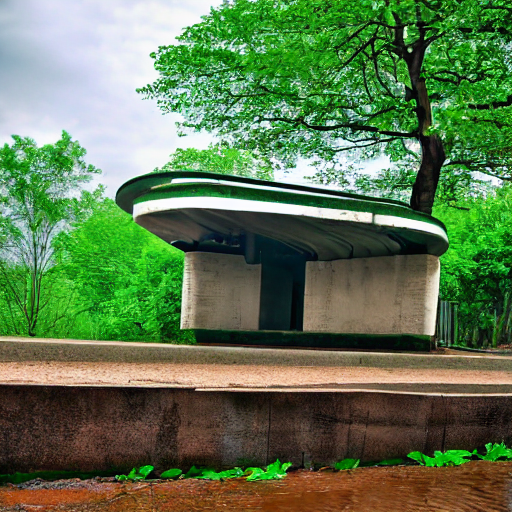

In [31]:
gen_data[0]["images"][1]

## Or we may run large-scale experiments

In [32]:
set_seeds(0)
train_dataset = EmbeddingsDataset(
        train_df,
        image_embeddings=expanded_features[train_df.original_index]
    )
val_dataset = EmbeddingsDataset(
        val_df,
        image_embeddings=expanded_features[val_df.original_index]
    )

In [33]:
param_grid = {
    'timesteps': [1000],
    'num_layers': [6, 8],
    'num_heads': [4, 8],
    'hidden_dim':[32, 64, 128],
    'num_tokens': [16, 32],
    'learning_rate': [1e-4],
    'optimizers': ['adamw'],
    #'schedulers': ['reduce_on_plateau', 'cosine'],
    'schedulers': ['reduce_on_plateau'],
    'batch_size': [64],
    'noise_schedule': ["laplace", "squaredcos_cap_v2"],
    'samples_per_user': [100],
    'clip_sample': [False],
    'objective':["sample", "epsilon", "v_prediction"],
    'img_embed_dim': [1024]
}

savedir = "../data/flickr/evaluation/diffusion_priors/models/weights/rdp_experiments"
#savedir = "../data/flickr/evaluation/diffusion_priors/models/weights/experiment_2"

In [34]:

run_grid_search(
    train_df=train_df,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    param_grid=param_grid,
    savedir=savedir,
    unique_users = len(unique_users)
                )

Hyperparameter combinations:   0%|          | 0/144 [00:00<?, ?it/s]

Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:   1%|          | 1/144 [03:10<7:34:51, 190.85s/it]

Early stopping with best val loss: 0.10183087442860458!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:   1%|▏         | 2/144 [08:55<11:06:25, 281.59s/it]

Early stopping with best val loss: 0.5423081318537394!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:   2%|▏         | 3/144 [13:52<11:18:03, 288.53s/it]

Early stopping with best val loss: 0.4697657895810676!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:   3%|▎         | 4/144 [17:04<9:43:48, 250.21s/it] 

Early stopping with best val loss: 0.1556012233098348!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:   3%|▎         | 5/144 [21:27<9:50:51, 255.04s/it]

Early stopping with best val loss: 0.5654234705549298!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:   4%|▍         | 6/144 [26:45<10:35:33, 276.33s/it]

Early stopping with best val loss: 0.4388982825206988!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:   5%|▍         | 7/144 [33:22<12:00:40, 315.63s/it]

Early stopping with best val loss: 0.09482712569561871!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:   6%|▌         | 8/144 [38:02<11:30:07, 304.46s/it]

Early stopping with best val loss: 0.2827840908007188!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:   6%|▋         | 9/144 [44:05<12:06:10, 322.75s/it]

Early stopping with best val loss: 0.3490656849109765!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:   7%|▋         | 10/144 [46:03<9:39:30, 259.48s/it]

Early stopping with best val loss: 0.15548057583245364!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:   8%|▊         | 11/144 [50:08<9:25:25, 255.08s/it]

Early stopping with best val loss: 0.29955850044886273!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:   8%|▊         | 12/144 [54:26<9:23:24, 256.09s/it]

Early stopping with best val loss: 0.39029400818275684!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:   9%|▉         | 13/144 [1:00:42<10:38:07, 292.27s/it]

Early stopping with best val loss: 0.09003332437890949!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  10%|▉         | 14/144 [1:05:06<10:14:54, 283.81s/it]

Early stopping with best val loss: 0.2672630006616766!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  10%|█         | 15/144 [1:10:04<10:19:15, 288.02s/it]

Early stopping with best val loss: 0.3474024877403722!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:  11%|█         | 16/144 [1:12:16<8:34:02, 240.95s/it] 

Early stopping with best val loss: 0.15373509219198517!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  12%|█▏        | 17/144 [1:16:36<8:42:16, 246.74s/it]

Early stopping with best val loss: 0.29876733097163116!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  12%|█▎        | 18/144 [1:21:16<8:59:18, 256.82s/it]

Early stopping with best val loss: 0.38270278681408276!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:  13%|█▎        | 19/144 [1:25:51<9:06:32, 262.34s/it]

Early stopping with best val loss: 0.09434798043785673!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  14%|█▍        | 20/144 [1:29:37<8:39:14, 251.24s/it]

Early stopping with best val loss: 0.25053613610339887!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  15%|█▍        | 21/144 [1:34:13<8:50:31, 258.79s/it]

Early stopping with best val loss: 0.34351097814964526!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:  15%|█▌        | 22/144 [1:36:50<7:43:54, 228.15s/it]

Early stopping with best val loss: 0.14925787349541983!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  16%|█▌        | 23/144 [1:39:58<7:15:56, 216.17s/it]

Early stopping with best val loss: 0.26818327966964606!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  17%|█▋        | 24/144 [1:45:04<8:06:30, 243.25s/it]

Early stopping with best val loss: 0.3761830483422135!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:  17%|█▋        | 25/144 [1:52:11<9:51:19, 298.14s/it]

Early stopping with best val loss: 0.08514702726494182!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  18%|█▊        | 26/144 [1:55:01<8:31:03, 259.86s/it]

Early stopping with best val loss: 0.2522962535872604!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  19%|█▉        | 27/144 [1:58:50<8:08:42, 250.62s/it]

Early stopping with best val loss: 0.3427745835347609!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:  19%|█▉        | 28/144 [2:01:06<6:58:09, 216.29s/it]

Early stopping with best val loss: 0.1526216593655673!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  20%|██        | 29/144 [2:03:29<6:12:11, 194.19s/it]

Early stopping with best val loss: 0.2713068922360738!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  21%|██        | 30/144 [2:07:11<6:25:02, 202.65s/it]

Early stopping with best val loss: 0.3790061663497578!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:  22%|██▏       | 31/144 [2:14:37<8:39:13, 275.69s/it]

Early stopping with best val loss: 0.08911843665621498!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  22%|██▏       | 32/144 [2:17:48<7:47:08, 250.25s/it]

Early stopping with best val loss: 0.24881821012858188!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  23%|██▎       | 33/144 [2:22:49<8:10:57, 265.38s/it]

Early stopping with best val loss: 0.34189198233864526!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:  24%|██▎       | 34/144 [2:25:53<7:21:42, 240.94s/it]

Early stopping with best val loss: 0.15093833524169345!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  24%|██▍       | 35/144 [2:28:03<6:17:06, 207.58s/it]

Early stopping with best val loss: 0.27502974461425433!
Running configuration: timesteps=1000, num_layers=6, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  25%|██▌       | 36/144 [2:32:05<6:32:31, 218.07s/it]

Early stopping with best val loss: 0.3807143397403486!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:  26%|██▌       | 37/144 [2:36:43<7:00:56, 236.05s/it]

Early stopping with best val loss: 0.09977632264296214!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  26%|██▋       | 38/144 [2:40:39<6:57:02, 236.06s/it]

Early stopping with best val loss: 0.5442513733199148!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  27%|██▋       | 39/144 [2:44:03<6:35:59, 226.28s/it]

Early stopping with best val loss: 0.4725988001534433!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:  28%|██▊       | 40/144 [2:46:55<6:04:15, 210.15s/it]

Early stopping with best val loss: 0.15473641726103696!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  28%|██▊       | 41/144 [2:52:23<7:01:22, 245.47s/it]

Early stopping with best val loss: 0.5626434286435446!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  29%|██▉       | 42/144 [2:58:44<8:06:10, 285.99s/it]

Early stopping with best val loss: 0.4323638108643619!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:  30%|██▉       | 43/144 [3:04:39<8:36:30, 306.83s/it]

Early stopping with best val loss: 0.09343946409044844!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  31%|███       | 44/144 [3:08:59<8:07:57, 292.78s/it]

Early stopping with best val loss: 0.28131265531886707!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  31%|███▏      | 45/144 [3:14:17<8:15:15, 300.16s/it]

Early stopping with best val loss: 0.3523005373550184!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:  32%|███▏      | 46/144 [3:17:47<7:26:14, 273.21s/it]

Early stopping with best val loss: 0.15144209518577112!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  33%|███▎      | 47/144 [3:20:16<6:21:32, 236.00s/it]

Early stopping with best val loss: 0.331340107050809!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  33%|███▎      | 48/144 [3:24:40<6:31:04, 244.42s/it]

Early stopping with best val loss: 0.3838596199498032!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:  34%|███▍      | 49/144 [3:29:38<6:52:26, 260.49s/it]

Early stopping with best val loss: 0.09241984265320229!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  35%|███▍      | 50/144 [3:34:56<7:15:01, 277.67s/it]

Early stopping with best val loss: 0.2687137885527177!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  35%|███▌      | 51/144 [3:41:09<7:54:41, 306.25s/it]

Early stopping with best val loss: 0.3470304608345032!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:  36%|███▌      | 52/144 [3:44:26<6:59:33, 273.63s/it]

Early stopping with best val loss: 0.14876985640236826!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  37%|███▋      | 53/144 [3:48:47<6:48:54, 269.60s/it]

Early stopping with best val loss: 0.2970010448585857!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  38%|███▊      | 54/144 [3:52:12<6:15:24, 250.28s/it]

Early stopping with best val loss: 0.38503766601735895!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:  38%|███▊      | 55/144 [4:00:33<8:03:06, 325.69s/it]

Early stopping with best val loss: 0.08523999109412685!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  39%|███▉      | 56/144 [4:04:22<7:15:04, 296.64s/it]

Early stopping with best val loss: 0.2500236707203316!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  40%|███▉      | 57/144 [4:08:22<6:45:32, 279.68s/it]

Early stopping with best val loss: 0.3423459069295363!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:  40%|████      | 58/144 [4:11:34<6:03:03, 253.30s/it]

Early stopping with best val loss: 0.14916974328684085!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  41%|████      | 59/144 [4:14:09<5:17:11, 223.90s/it]

Early stopping with best val loss: 0.27601771101807104!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  42%|████▏     | 60/144 [4:17:08<4:54:34, 210.42s/it]

Early stopping with best val loss: 0.3854329188664754!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:  42%|████▏     | 61/144 [4:23:14<5:55:30, 257.00s/it]

Early stopping with best val loss: 0.08740808340636166!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  43%|████▎     | 62/144 [4:25:14<4:54:53, 215.78s/it]

Early stopping with best val loss: 0.2542830809499278!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  44%|████▍     | 63/144 [4:29:58<5:19:15, 236.49s/it]

Early stopping with best val loss: 0.34214553688511706!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:  44%|████▍     | 64/144 [4:34:25<5:27:17, 245.47s/it]

Early stopping with best val loss: 0.14386813161951123!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  45%|████▌     | 65/144 [4:37:13<4:52:29, 222.15s/it]

Early stopping with best val loss: 0.2690550635258357!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  46%|████▌     | 66/144 [4:41:20<4:58:33, 229.66s/it]

Early stopping with best val loss: 0.38167274630430975!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:  47%|████▋     | 67/144 [4:47:45<5:54:45, 276.44s/it]

Early stopping with best val loss: 0.0867557471448725!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  47%|████▋     | 68/144 [4:51:54<5:39:46, 268.24s/it]

Early stopping with best val loss: 0.2473969893022017!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  48%|████▊     | 69/144 [4:56:59<5:48:57, 279.16s/it]

Early stopping with best val loss: 0.34147389097647235!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:  49%|████▊     | 70/144 [5:00:15<5:13:21, 254.07s/it]

Early stopping with best val loss: 0.14630320036050046!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  49%|████▉     | 71/144 [5:03:26<4:46:19, 235.33s/it]

Early stopping with best val loss: 0.26402557663845294!
Running configuration: timesteps=1000, num_layers=6, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  50%|█████     | 72/144 [5:06:14<4:18:11, 215.16s/it]

Early stopping with best val loss: 0.384340940099774!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:  51%|█████     | 73/144 [5:14:04<5:45:03, 291.60s/it]

Early stopping with best val loss: 0.09690475170359467!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  51%|█████▏    | 74/144 [5:18:51<5:38:28, 290.12s/it]

Early stopping with best val loss: 0.5461132165157434!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  52%|█████▏    | 75/144 [5:24:50<5:57:32, 310.91s/it]

Early stopping with best val loss: 0.46963595802133734!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:  53%|█████▎    | 76/144 [5:29:58<5:51:13, 309.90s/it]

Early stopping with best val loss: 0.1546210709846381!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  53%|█████▎    | 77/144 [5:34:45<5:38:15, 302.91s/it]

Early stopping with best val loss: 0.5651344331828031!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  54%|█████▍    | 78/144 [5:41:56<6:15:34, 341.43s/it]

Early stopping with best val loss: 0.43712319207913947!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:  55%|█████▍    | 79/144 [5:46:30<5:48:10, 321.38s/it]

Early stopping with best val loss: 0.09879606284878471!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  56%|█████▌    | 80/144 [5:52:18<5:51:01, 329.09s/it]

Early stopping with best val loss: 0.2806270628264456!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  56%|█████▋    | 81/144 [5:57:06<5:32:42, 316.87s/it]

Early stopping with best val loss: 0.35490159193674725!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:  57%|█████▋    | 82/144 [6:00:45<4:57:04, 287.50s/it]

Early stopping with best val loss: 0.15129184542280255!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  58%|█████▊    | 83/144 [6:08:07<5:39:21, 333.79s/it]

Early stopping with best val loss: 0.3115486881949685!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  58%|█████▊    | 84/144 [6:15:23<6:04:33, 364.56s/it]

Early stopping with best val loss: 0.37660538427757495!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:  59%|█████▉    | 85/144 [6:21:26<5:57:53, 363.95s/it]

Early stopping with best val loss: 0.09300984374501488!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  60%|█████▉    | 86/144 [6:29:51<6:32:54, 406.45s/it]

Early stopping with best val loss: 0.26231371092073846!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  60%|██████    | 87/144 [6:36:46<6:28:35, 409.04s/it]

Early stopping with best val loss: 0.3464895017219312!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:  61%|██████    | 88/144 [6:41:31<5:47:02, 371.82s/it]

Early stopping with best val loss: 0.15000896968624808!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  62%|██████▏   | 89/144 [6:46:43<5:24:12, 353.68s/it]

Early stopping with best val loss: 0.30408463965762744!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  62%|██████▎   | 90/144 [6:52:41<5:19:36, 355.12s/it]

Early stopping with best val loss: 0.38289207671627856!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:  63%|██████▎   | 91/144 [7:01:33<6:00:34, 408.19s/it]

Early stopping with best val loss: 0.09093019817814682!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  64%|██████▍   | 92/144 [7:04:58<5:00:59, 347.29s/it]

Early stopping with best val loss: 0.2533768049695275!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  65%|██████▍   | 93/144 [7:09:43<4:39:09, 328.41s/it]

Early stopping with best val loss: 0.34432979876344855!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:  65%|██████▌   | 94/144 [7:13:50<4:13:29, 304.19s/it]

Early stopping with best val loss: 0.1506252916473331!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  66%|██████▌   | 95/144 [7:17:06<3:41:54, 271.73s/it]

Early stopping with best val loss: 0.27630931771162787!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  67%|██████▋   | 96/144 [7:21:10<3:30:38, 263.31s/it]

Early stopping with best val loss: 0.38662680983543396!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:  67%|██████▋   | 97/144 [7:28:54<4:13:20, 323.41s/it]

Early stopping with best val loss: 0.08532445245619977!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  68%|██████▊   | 98/144 [7:34:51<4:15:52, 333.75s/it]

Early stopping with best val loss: 0.24790679144136835!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  69%|██████▉   | 99/144 [7:41:07<4:19:37, 346.16s/it]

Early stopping with best val loss: 0.3424633605913682!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:  69%|██████▉   | 100/144 [7:44:40<3:44:40, 306.38s/it]

Early stopping with best val loss: 0.14943586312460178!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  70%|███████   | 101/144 [7:48:14<3:19:34, 278.48s/it]

Early stopping with best val loss: 0.26863219792192633!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  71%|███████   | 102/144 [7:54:53<3:40:18, 314.74s/it]

Early stopping with best val loss: 0.3746335253571019!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:  72%|███████▏  | 103/144 [8:01:51<3:56:19, 345.84s/it]

Early stopping with best val loss: 0.0895608135245063!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  72%|███████▏  | 104/144 [8:07:25<3:48:10, 342.26s/it]

Early stopping with best val loss: 0.24766426014177728!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  73%|███████▎  | 105/144 [8:14:06<3:53:55, 359.88s/it]

Early stopping with best val loss: 0.34117271412502637!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:  74%|███████▎  | 106/144 [8:17:39<3:19:54, 315.65s/it]

Early stopping with best val loss: 0.14867488972165369!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  74%|███████▍  | 107/144 [8:20:45<2:50:40, 276.76s/it]

Early stopping with best val loss: 0.2658478355768955!
Running configuration: timesteps=1000, num_layers=8, heads=4, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  75%|███████▌  | 108/144 [8:26:24<2:57:16, 295.45s/it]

Early stopping with best val loss: 0.38091522455215454!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:  76%|███████▌  | 109/144 [8:33:58<3:20:07, 343.07s/it]

Early stopping with best val loss: 0.09655135215231866!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  76%|███████▋  | 110/144 [8:39:03<3:07:56, 331.66s/it]

Early stopping with best val loss: 0.5443381883881309!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  77%|███████▋  | 111/144 [8:43:55<2:55:55, 319.87s/it]

Early stopping with best val loss: 0.4713412116874348!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:  78%|███████▊  | 112/144 [8:48:30<2:43:21, 306.29s/it]

Early stopping with best val loss: 0.15638982301408594!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  78%|███████▊  | 113/144 [8:53:44<2:39:27, 308.62s/it]

Early stopping with best val loss: 0.5661512902288726!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  79%|███████▉  | 114/144 [9:00:08<2:45:36, 331.23s/it]

Early stopping with best val loss: 0.43587425802693225!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:  80%|███████▉  | 115/144 [9:08:26<3:04:21, 381.41s/it]

Early stopping with best val loss: 0.09280857037414204!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  81%|████████  | 116/144 [9:14:37<2:56:29, 378.21s/it]

Early stopping with best val loss: 0.2934109415068771!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  81%|████████▏ | 117/144 [9:23:07<3:07:58, 417.70s/it]

Early stopping with best val loss: 0.34795162172028515!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:  82%|████████▏ | 118/144 [9:27:03<2:37:21, 363.13s/it]

Early stopping with best val loss: 0.15233597746401123!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  83%|████████▎ | 119/144 [9:33:01<2:30:39, 361.59s/it]

Early stopping with best val loss: 0.3199267170645974!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  83%|████████▎ | 120/144 [9:41:54<2:45:12, 413.04s/it]

Early stopping with best val loss: 0.3782978021737301!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:  84%|████████▍ | 121/144 [9:48:11<2:34:15, 402.40s/it]

Early stopping with best val loss: 0.09232526249957806!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  85%|████████▍ | 122/144 [9:54:45<2:26:36, 399.84s/it]

Early stopping with best val loss: 0.2716165401718833!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  85%|████████▌ | 123/144 [10:02:35<2:27:14, 420.71s/it]

Early stopping with best val loss: 0.34613897493391327!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:  86%|████████▌ | 124/144 [10:08:29<2:13:37, 400.86s/it]

Early stopping with best val loss: 0.14857195453210312!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  87%|████████▋ | 125/144 [10:16:16<2:13:11, 420.61s/it]

Early stopping with best val loss: 0.28083436507167236!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  88%|████████▊ | 126/144 [10:24:34<2:13:10, 443.92s/it]

Early stopping with best val loss: 0.3754235235127536!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:  88%|████████▊ | 127/144 [10:28:35<1:48:28, 382.86s/it]

Early stopping with best val loss: 0.09704380188927506!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  89%|████████▉ | 128/144 [10:34:10<1:38:18, 368.68s/it]

Early stopping with best val loss: 0.24655222576675992!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  90%|████████▉ | 129/144 [10:40:14<1:31:45, 367.06s/it]

Early stopping with best val loss: 0.34279060092839325!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:  90%|█████████ | 130/144 [10:43:30<1:13:42, 315.87s/it]

Early stopping with best val loss: 0.15109253697323077!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  91%|█████████ | 131/144 [10:46:17<58:44, 271.14s/it]  

Early stopping with best val loss: 0.2720204736247207!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  92%|█████████▏| 132/144 [10:51:23<56:18, 281.56s/it]

Early stopping with best val loss: 0.38015327309117175!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:  92%|█████████▏| 133/144 [11:01:20<1:08:58, 376.20s/it]

Early stopping with best val loss: 0.08340384043527371!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  93%|█████████▎| 134/144 [11:07:14<1:01:37, 369.79s/it]

Early stopping with best val loss: 0.24992186192310217!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  94%|█████████▍| 135/144 [11:12:35<53:14, 354.99s/it]  

Early stopping with best val loss: 0.3423516389095422!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:  94%|█████████▍| 136/144 [11:16:08<41:39, 312.48s/it]

Early stopping with best val loss: 0.14730598438869824!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  95%|█████████▌| 137/144 [11:20:08<33:55, 290.73s/it]

Early stopping with best val loss: 0.2707743319598111!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=16, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  96%|█████████▌| 138/144 [11:25:20<29:42, 297.10s/it]

Early stopping with best val loss: 0.37699003382162616!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=sample


Hyperparameter combinations:  97%|█████████▋| 139/144 [11:33:48<30:00, 360.18s/it]

Early stopping with best val loss: 0.08627995013287573!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  97%|█████████▋| 140/144 [11:39:53<24:06, 361.68s/it]

Early stopping with best val loss: 0.24825840601415344!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=laplace, samples_per_user=100, objective=v_prediction


Hyperparameter combinations:  98%|█████████▊| 141/144 [11:45:27<17:40, 353.48s/it]

Early stopping with best val loss: 0.34372617530100275!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=sample


Hyperparameter combinations:  99%|█████████▊| 142/144 [11:50:45<11:25, 342.75s/it]

Early stopping with best val loss: 0.1457137777046724!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=epsilon


Hyperparameter combinations:  99%|█████████▉| 143/144 [11:54:04<04:59, 299.54s/it]

Early stopping with best val loss: 0.2604272306868524!
Running configuration: timesteps=1000, num_layers=8, heads=8, num_tokens=32, learning_rate=0.0001, clip_sample=False, optimizer=adamw, scheduler=reduce_on_plateau, batch_size=64, noise_schedule=squaredcos_cap_v2, samples_per_user=100, objective=v_prediction


Hyperparameter combinations: 100%|██████████| 144/144 [12:00:51<00:00, 300.36s/it]

Early stopping with best val loss: 0.375848979660959!
Experimentation complete. Results saved to results.csv at ../data/flickr/evaluation/diffusion_priors/models/weights/rdp_experiments
